# Visualisation of the captions predicted by the captioning model

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from pycocotools.coco import COCO
from Utils.eval import COCOEvalCap
import pandas as pd

In [2]:
IMG_PATH = 'C:/Users/rapha/Documents/Dataset/COCOCaptions/img/val2014'

annotation_file = './example/captions_val2014.json'

In [3]:
model_path_newCA = ['res_files/new_CA/2ca_ep2/eval_2ca_ep2_t0.0.json', 'res_files/new_CA/2ca_ep5/eval_2ca_ep5_t0.0.json']

## 1. Compute the automatic metrics

Use of the [pycocoevalcap package](https://github.com/salaniz/pycocoevalcap) to compute the following metrics : BLEU, ROUGE, METEOR, CIDEr

In [4]:
coco = COCO(annotation_file)
def evaluate_model(list_path, coco):
    coco_eval_list = []
    for i in range(len(list_path)):
        coco_result = coco.loadRes(list_path[i])

        # create coco_eval object by taking coco and coco_result
        coco_eval = COCOEvalCap(coco, coco_result)
        coco_eval.params['image_id'] = coco_result.getImgIds()
        coco_eval.evaluate()
        coco_eval_list.append(coco_eval)
    return coco_eval_list


loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [5]:
coco_eval_newCA = evaluate_model(model_path_newCA, coco)

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 39514, 'reflen': 37899, 'guess': [39514, 35466, 31418, 27370], 'correct': [23742, 11620, 4861, 1920]}
ratio: 1.0426132615636021
Bleu_1: 0.601
Bleu_2: 0.444
Bleu_3: 0.312
Bleu_4: 0.215
computing METEOR score...
METEOR: 0.210
computing Rouge score...
ROUGE_L: 0.481
computing CIDEr score...
CIDEr: 0.719
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 43903, 'reflen': 39636, 'guess': [43903, 39853, 35803, 31753], 'correct': [25766, 13128, 5797, 2429]}
ratio: 1.10765465738215
Bleu_1: 0.587
Bleu_2: 0.440
Bleu_3: 0.315
Bleu_4: 0.221
computing METEOR score...
METEOR: 0.225
computing Rouge score...
ROUGE_L: 0.491
computing CIDEr score...
CIDEr: 0.776


### Example of a sample from the dataset:

A group of people standing outside of a building.
People standing outside the doors of a stone building with a clock above the doors.
The clock on the front of a building. 
People walking inside of a large building wit a clock on the wall.
In the station people are standing and talking.


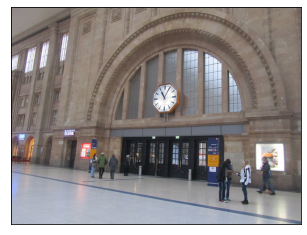

In [6]:
f, ax = plt.subplots()
len_image_id = 6
id = list(coco.imgToAnns.keys())[np.random.randint(40000)]
x = coco.imgToAnns[id]
filename = 'COCO_val2014_000000{}{}.jpg'.format('0'*(len_image_id-len(str(id))), id)
img = cv2.imread(os.path.join(IMG_PATH, filename))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])
for i in range(len(x)):
    print(x[i]['caption'])
plt.show()

## 2. Results of the computed metrics

In [19]:
ClipClap = {'Bleu_1': None, 'Bleu_2': None, 'Bleu_3': None,'Bleu_4':0.335, 'METEOR':0.274, 'ROUGE_L': None, 'CIDEr':1.13}

In [20]:
def plot_with_df(coco_evals, columns, SOTA=None, display_df=True, **kwargs):
    """
    Plots the results of the automatic metrics computed with the pycocoevalcap package

    @param coco_evals : list of the coco_eval objects corresponding each to a JSON file
    @param columns : labels for each model (SOTA model included)
    @param SOTA : dictionary with the metrics values of a SOTA model for comparison purpose
    @param display_df : boolean indicating if a table with the computed metrics need to be displayed
    """
    # List of dict
    list_data = [coco_evals[i].eval for i in range(len(coco_evals))]
    if SOTA is not None:
        list_data.insert(0, SOTA)

    df = pd.DataFrame(data = list_data, index=columns)
    df = df.T


    ax = df.plot(kind='bar', rot=0, xlabel='Metrics', ylabel='Value',figsize=(10, 8), table=False, edgecolor='black', **kwargs)

    # space for the annotation
    ax.margins(y=0.1)

    # legend
    ax.legend(title='Model', bbox_to_anchor=(1, 1.02), loc='upper left')
    plt.show()
    if display_df:
        display(df)

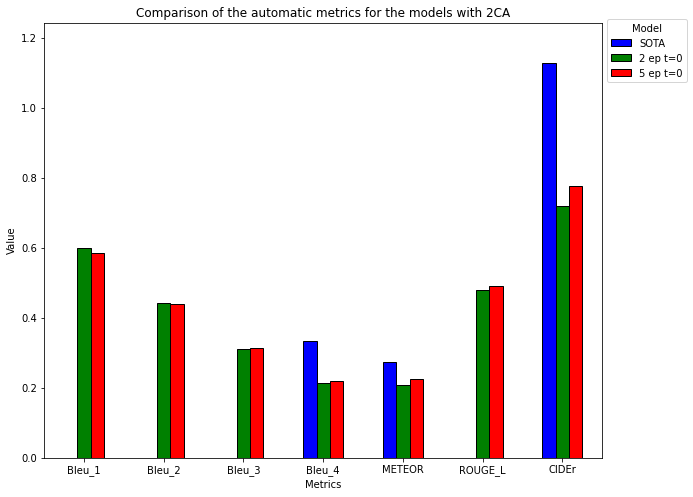

SOTA  2 ep t=0  5 ep t=0
Bleu_1     NaN  0.600850  0.586885
Bleu_2     NaN  0.443690  0.439689
Bleu_3     NaN  0.312298  0.315155
Bleu_4   0.335  0.214998  0.221210
METEOR   0.274  0.209712  0.224529
ROUGE_L    NaN  0.481186  0.490612
CIDEr    1.130  0.719249  0.776050

In [21]:
plot_with_df(coco_eval_newCA, ['SOTA', '2 ep t=0', '5 ep t=0'], SOTA=ClipClap, display_df=True, color=['blue', 'green', 'red'], title='Comparison of the automatic metrics for the models with 2CA')

## 3. Visualisation of some captions

In [10]:
n_visu = 10 # number of samples to visualize

### 3.1 The worst results

In [11]:
target_metric = 'CIDEr'

In [12]:
coco_eval_sort_newCA = sorted(coco_eval_newCA, key=lambda x:x.eval[target_metric])
eval_sorted_newCA = sorted(coco_eval_sort_newCA[-1].evalImgs, key=lambda x:x[target_metric])

In [13]:
def plot_image_captions(target_imgs, coco_eval, coco_eval2=None, model_names=None):
    if model_names is None:
        model_names = ['Model 1', 'Model 2']
    for i, x in enumerate(target_imgs):
        f, ax = plt.subplots()
        len_image_id = 6
        filename = 'COCO_val2014_000000{}{}.jpg'.format('0'*(len_image_id-len(str(x['image_id']))), x['image_id'])
        img = cv2.imread(os.path.join(IMG_PATH, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()
        print('{} : {}'.format(model_names[0],
            coco_eval.cocoRes.imgToAnns[x['image_id']][0]['caption']))

        if coco_eval2 is not None:
            print('{} : {}'.format( model_names[1],
                coco_eval2.cocoRes.imgToAnns[x['image_id']][0]['caption']))
        print('GT 1 : ', coco.imgToAnns[x['image_id']][0]['caption'])
        print('GT 2 : ', coco.imgToAnns[x['image_id']][1]['caption'])
        if coco_eval2 is not None:
            dataframe = pd.DataFrame([coco_eval.imgToEval[x['image_id']],  coco_eval2.imgToEval[x['image_id']]], index=model_names)
        else:
            dataframe = pd.DataFrame([coco_eval.imgToEval[x['image_id']]], index=[model_names[0]])
        display(dataframe)
        print('---'*10)

In [14]:
worst_cap = eval_sorted_newCA[0:n_visu]

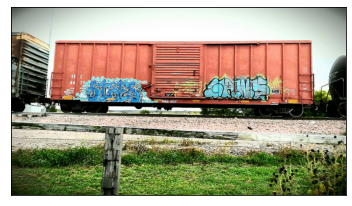

Model (5 ep) : graff graff graff graff graff graff graff graff graff graff graff graff graff graff graff
Model (2 ep) : a graffiti graffiti graffiti graffiti graffiti graffiti graffiti graffiti graffiti graff
GT 1 :  A train car with blue graffiti on the side of it .
GT 2 :  an image of a train with graffiti on the side


image_id        Bleu_1        Bleu_2        Bleu_3  \
Model (5 ep)      7211  6.666667e-17  6.900656e-17  7.155046e-17   
Model (2 ep)      7211  1.818182e-01  4.264014e-09  1.264149e-11   

                    Bleu_4   METEOR   ROUGE_L     CIDEr  
Model (5 ep)  7.432998e-17  0.00000  0.000000  0.000000  
Model (2 ep)  7.088857e-13  0.08377  0.203673  0.128857

------------------------------


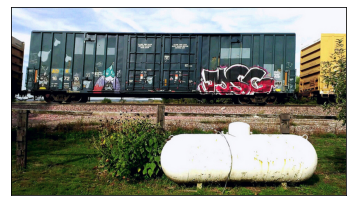

Model (5 ep) : graff graff graff graff graff graff graff graff graff graff graff graff graff graff graff
Model (2 ep) : a graffiti graffiti graffiti graffiti graffiti graffiti graffiti graffiti graffiti graff
GT 1 :  a train cart is near a white tank
GT 2 :  A freight train traveling past a propane tank.


image_id        Bleu_1        Bleu_2        Bleu_3  \
Model (5 ep)    356298  6.666667e-17  6.900656e-17  7.155046e-17   
Model (2 ep)    356298  1.818182e-01  1.348400e-01  1.264149e-06   

                    Bleu_4    METEOR   ROUGE_L     CIDEr  
Model (5 ep)  7.432998e-17  0.000000  0.000000  0.000000  
Model (2 ep)  3.986357e-09  0.076275  0.192126  0.036746

------------------------------


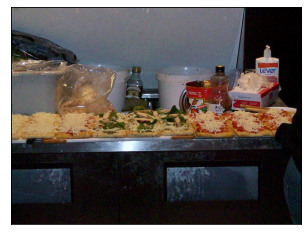

Model (5 ep) : a counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter counter
Model (2 ep) : a table with a table with a table with a table with a table with a table with a table with a table with a table with a table with
GT 1 :  A picture of some food on a table.
GT 2 :  A table with three each of three different kinds of pizza.


image_id    Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    307166  0.033333  1.072113e-09  3.449644e-12  1.974648e-13   
Model (2 ep)    307166  0.166667  1.313064e-01  8.507553e-02  1.228889e-05   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.015936  0.058767  1.818739e-10  
Model (2 ep)  0.180679  0.247967  1.223947e-03

------------------------------


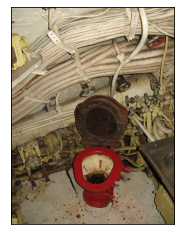

Model (5 ep) : a fire hydrant is a fire hydrant is a fire hydrant is a fire hydrant is a fire hydrant is a fire hydrant is
Model (2 ep) : a red and white topped topped with a red and white topped with a red and white topped with a red and white topped with
GT 1 :  A red toilet in a very small bathroom.
GT 2 :  An old toilet painted red with a wooden lid. 


image_id    Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    263796  0.083333  1.903467e-09  5.481374e-12  2.975858e-13   
Model (2 ep)    263796  0.200000  1.290994e-01  8.982012e-07  2.395657e-09   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.035556  0.137387  1.290274e-09  
Model (2 ep)  0.098720  0.247716  2.110932e-03

------------------------------


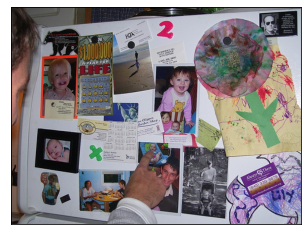

Model (5 ep) : a child with a child with a child with a child with a child with a child with a child with a child with a child with a child with
Model (2 ep) : a child with a child with a child with a child with a child with a child with a child with a child with a child with a child with
GT 1 :  A man pointing to a baby's picture on a bulletin board. 
GT 2 :  A man pointing to a baby picture on a refrigerator door.


image_id  Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    191270     0.1  1.856953e-09  4.975247e-12  2.598783e-13   
Model (2 ep)    191270     0.1  1.856953e-09  4.975247e-12  2.598783e-13   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.086549  0.159686  1.361407e-09  
Model (2 ep)  0.086549  0.159686  1.361407e-09

------------------------------


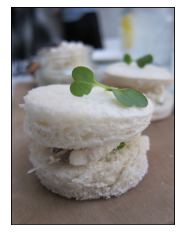

Model (5 ep) : a white sandy white sandy white sandy white sandy white sandy white sandy white sandy white sandy white sandy white sand
Model (2 ep) : a white plate with a white table cloth
GT 1 :  Two pieces of bread with a leafy green on top of it.
GT 2 :  This finger food is topped with a green leaf


image_id    Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    428712  0.047619  1.543033e-09  5.004174e-12  2.888558e-13   
Model (2 ep)    428712  0.375000  2.314550e-01  2.074566e-06  6.500593e-09   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.016360  0.075031  3.906387e-09  
Model (2 ep)  0.074456  0.326786  1.135231e-02

------------------------------


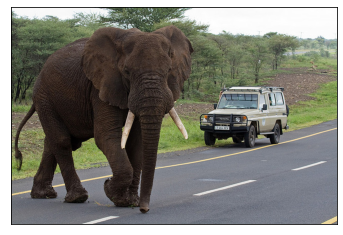

Model (5 ep) : a truck driving truck driving truck driving truck driving truck driving truck driving truck driving truck driving truck driving truck
Model (2 ep) : a large elephant walking through a field
GT 1 :  An elephant is crossing a road while a jeep is parked watching. 
GT 2 :  An elephant crossing the road in front of an SUV.



image_id    Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    555472  0.050000  1.622214e-09  5.268027e-12  3.045256e-13   
Model (2 ep)    555472  0.619198  4.229931e-01  3.142087e-01  5.091997e-05   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.043425  0.070930  4.028056e-09  
Model (2 ep)  0.187321  0.379471  7.287038e-01

------------------------------


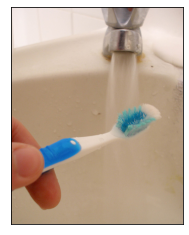

Model (5 ep) : a blue tooth blue tooth blue tooth blue tooth blue tooth blue tooth blue tooth blue tooth blue tooth blue to
Model (2 ep) : a toothbrush is a toothbrush is a toothbrush is a toothbrush is a toothbrush is
GT 1 :  A person holding a toothbrush under the running water of a faucet.
GT 2 :  A toothbrush being held under a water facet.


image_id    Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)     58079  0.047619  1.543033e-09  5.004174e-12  2.888558e-13   
Model (2 ep)     58079  0.333333  2.182179e-01  1.541508e-01  2.350520e-05   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.015474  0.075031  4.643732e-09  
Model (2 ep)  0.150701  0.321476  2.232545e-01

------------------------------


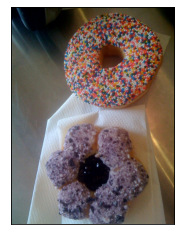

Model (5 ep) : a donut is a donut is a donut is a donut is a donut is a donut is a donut is a don
Model (2 ep) : a table with a table with a table with a table with a table with a table with a table with a table with a table with a table with
GT 1 :  A metal table holding two donuts covered in sprinkles.
GT 2 :  Two donuts are placed together on a napkin. 


image_id    Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    533750  0.130435  2.434924e-09  6.560201e-12  3.446913e-13   
Model (2 ep)    533750  0.133333  6.780635e-02  5.475968e-07  1.570380e-09   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.102128  0.195722  5.258184e-09  
Model (2 ep)  0.114091  0.219820  9.012426e-05

------------------------------


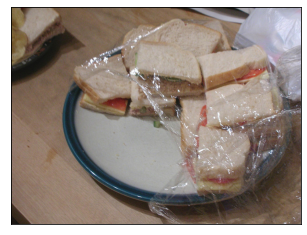

Model (5 ep) : a sandwich sandwich sandwich sandwich sandwich sandwich sandwich sandwich sandwich sandwich sandwich sandwich sandwich sandwich sand
Model (2 ep) : a sandwich on a plate with a fork
GT 1 :  A plate filled with little sandwiches covered in plastic wrap.
GT 2 :  A plate of sandwiches at a covered in plastic wrap


image_id  Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    187979  0.0625  2.041241e-09  6.676573e-12  3.889819e-13   
Model (2 ep)    187979  0.6250  2.988072e-01  2.459670e-06  7.386100e-09   

                METEOR   ROUGE_L         CIDEr  
Model (5 ep)  0.018018  0.088663  6.496607e-09  
Model (2 ep)  0.128372  0.375000  3.359682e-01

------------------------------


In [15]:
plot_image_captions(worst_cap, coco_eval_sort_newCA[-1], coco_eval_sort_newCA[0], model_names=['Model (5 ep)', 'Model (2 ep)'])

### 3.2 Some random results

In [16]:
n_visu = 10

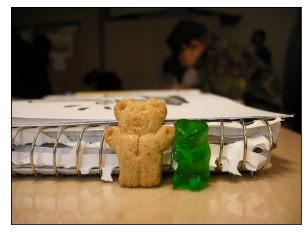

Model (5 ep) : a piece of paper with a picture of a teddy bear on it
Model (2 ep) : a teddy bear sitting on a table
GT 1 :  A bear cookie sitting next to a gummy bear 
GT 2 :  teddy bear like candy on a wooden table


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    334007  0.498594  0.339735  0.213383  0.000031  0.211487   
Model (2 ep)    334007  0.866878  0.612975  0.402369  0.000061  0.261870   

               ROUGE_L     CIDEr  
Model (5 ep)  0.378882  0.714613  
Model (2 ep)  0.658747  1.034767

------------------------------


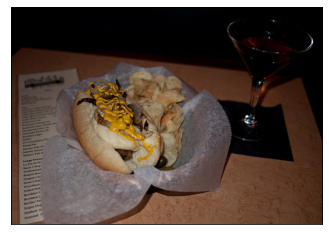

Model (5 ep) : a sandwich with a sandwich and a sandwich on a sandwich
Model (2 ep) : a hot dog with a hot dog on a hot dog on a hot dog on a hot dog on a hot dog on a hot dog on a hot
GT 1 :  a close up of a hot dog next to a drink on a table
GT 2 :  A Philly cheese steak with chips and a drink.


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    398604  0.727273  0.603023  0.343143  0.000047  0.148115   
Model (2 ep)    398604  0.266667  0.191785  0.137986  0.099320  0.173239   

               ROUGE_L     CIDEr  
Model (5 ep)  0.492598  0.129191  
Model (2 ep)  0.340510  0.002690

------------------------------


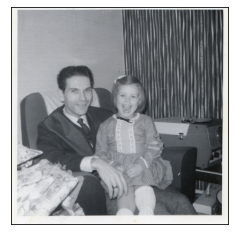

Model (5 ep) : a man and a woman are sitting on a couch
Model (2 ep) : a man and a woman are sitting on a couch
GT 1 :  an old photo of a little girl sitting on her dads lap 
GT 2 :  A man with a little girl sitting on his lap.


image_id  Bleu_1   Bleu_2  Bleu_3    Bleu_4    METEOR  ROUGE_L  \
Model (5 ep)    292082     0.6  0.57735     0.5  0.000065  0.209363      0.5   
Model (2 ep)    292082     0.6  0.57735     0.5  0.000065  0.209363      0.5   

                 CIDEr  
Model (5 ep)  0.426616  
Model (2 ep)  0.426616

------------------------------


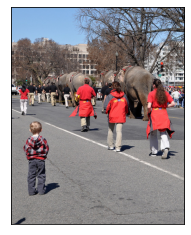

Model (5 ep) : a group of people walking down a street
Model (2 ep) : a group of people walking in a line
GT 1 :  A group of people and elephants on a street.
GT 2 :  People and elephants in a procession on a city street.


image_id    Bleu_1   Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)     24097  0.772185  0.62402  0.485657  0.377079  0.342149   
Model (2 ep)     24097  0.772185  0.62402  0.485657  0.377079  0.235911   

               ROUGE_L     CIDEr  
Model (5 ep)  0.698473  0.716493  
Model (2 ep)  0.582061  0.431081

------------------------------


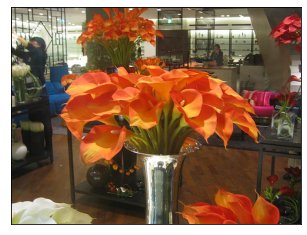

Model (5 ep) : a vase filled with flowers sitting on a table
Model (2 ep) : a vase of flowers in a vase on a table
GT 1 :  Some orange flowers in a tall silver vase
GT 2 :  Orange, red and white flowers in vases on tables.


image_id    Bleu_1        Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    254277  0.666667  9.128709e-09  2.283356e-11  1.186841e-12   
Model (2 ep)    254277  0.700000  5.577734e-01  4.268597e-01  5.773503e-05   

                METEOR   ROUGE_L     CIDEr  
Model (5 ep)  0.181360  0.521368  1.110496  
Model (2 ep)  0.226769  0.600000  1.203039

------------------------------


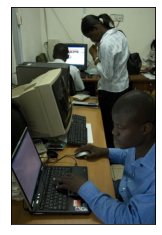

Model (5 ep) : a man sitting at a desk with a laptop computer
Model (2 ep) : a man is sitting on a desk
GT 1 :  several young students working at a desk with multiple computers
GT 2 :  A young man at his workstation examines the monitor of a lap top, with one hand on the keyboard and the other on the mouse.


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    113588  0.700000  0.623610  0.459821  0.343295  0.183279   
Model (2 ep)    113588  0.743038  0.655298  0.420683  0.000063  0.176933   

               ROUGE_L     CIDEr  
Model (5 ep)  0.435714  0.606291  
Model (2 ep)  0.534151  0.285203

------------------------------


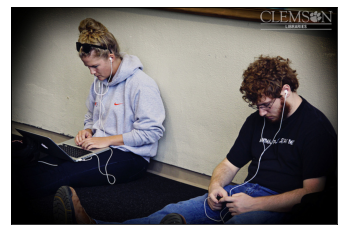

Model (5 ep) : two people sitting on a couch with their cell phones
Model (2 ep) : two people sitting on a couch with a laptop on their laps
GT 1 :  A couple of people sitting down by a wall.
GT 2 :  A girl working on a laptop next to a man on an music player.


image_id    Bleu_1    Bleu_2    Bleu_3        Bleu_4    METEOR  \
Model (5 ep)    227901  0.700000  0.483046  0.000003  8.034284e-09  0.208745   
Model (2 ep)    227901  0.833333  0.550482  0.000003  7.617472e-09  0.215424   

               ROUGE_L     CIDEr  
Model (5 ep)  0.318815  0.248773  
Model (2 ep)  0.350575  0.400233

------------------------------


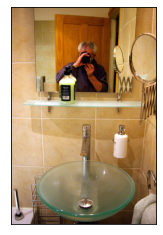

Model (5 ep) : a person taking a picture of a camera taking a picture of a camera taking a picture of a camera taking a picture of a camera taking a picture of
Model (2 ep) : a man is taking a bath in a bathroom
GT 1 :  A bathroom sink shapped like a glass bowl.
GT 2 :  A man that is standing with a mug in front of a mirror.


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    387362  0.200000  0.166091  0.125368  0.092427  0.220285   
Model (2 ep)    387362  0.888889  0.666667  0.398939  0.000057  0.316663   

               ROUGE_L     CIDEr  
Model (5 ep)  0.319372  0.013352  
Model (2 ep)  0.729915  0.738596

------------------------------


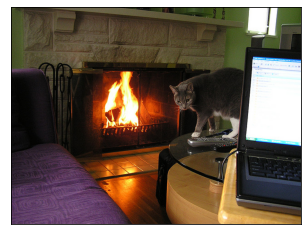

Model (5 ep) : a cat sitting on a laptop with a cat sitting on a laptop on a laptop on a laptop on a laptop on a laptop on a laptop on a
Model (2 ep) : a cat sitting on a laptop with a cat sitting on a laptop
GT 1 :  A cat in a living room with a burning fireplace.
GT 2 :  A cat standing on a table in front of the fireplace.


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    253665  0.200000  0.143839  0.090406  0.000013  0.129351   
Model (2 ep)    253665  0.461538  0.339683  0.218903  0.000032  0.154598   

               ROUGE_L     CIDEr  
Model (5 ep)  0.274775  0.003618  
Model (2 ep)  0.445255  0.426484

------------------------------


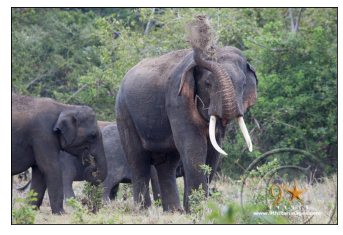

Model (5 ep) : a couple of elephants standing next to each other
Model (2 ep) : two elephants walking in the grass
GT 1 :  A herd lf elephants walking across a grass covered forest.
GT 2 :  Elephants out in the wild eating grass 


image_id    Bleu_1    Bleu_2    Bleu_3        Bleu_4    METEOR  \
Model (5 ep)    550872  0.444444  0.235702  0.000002  6.030725e-09  0.225348   
Model (2 ep)    550872  0.846482  0.757116  0.495026  7.648826e-05  0.328775   

               ROUGE_L     CIDEr  
Model (5 ep)  0.278539  0.680864  
Model (2 ep)  0.696347  1.282151

------------------------------


In [17]:
plot_image_captions(np.random.choice(eval_sorted_newCA, replace=False, size=n_visu), coco_eval_sort_newCA[-1], coco_eval_sort_newCA[0], model_names=['Model (5 ep)', 'Model (2 ep)'])

### 3.3 The best results

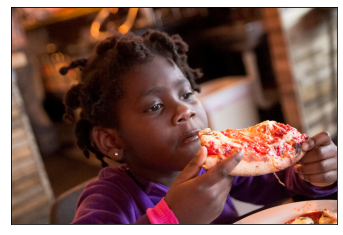

Model (5 ep) : a young girl is eating a slice of pizza
Model (2 ep) : a little girl is eating a pizza
GT 1 :  A child eating a piece of cheese pizza.
GT 2 :  An African American girl eating a slice of pizza.


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)     53990  0.888889  0.816497  0.724920  0.596949  0.540779   
Model (2 ep)     53990  0.743038  0.567505  0.382216  0.000059  0.332705   

               ROUGE_L     CIDEr  
Model (5 ep)  0.951267  3.582375  
Model (2 ep)  0.733467  1.975727

------------------------------


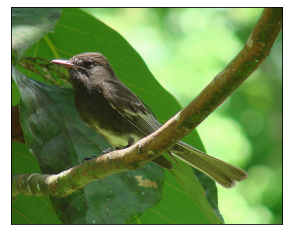

Model (5 ep) : a small bird perched on a tree branch
Model (2 ep) : a bird sitting on a branch
GT 1 :  A bird that is perched on a branch.
GT 2 :  A small bird perched on a branch with leaves


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    367433  1.000000  0.925820  0.829827  0.765206  0.424120   
Model (2 ep)    367433  0.716531  0.716531  0.716531  0.716531  0.370662   

               ROUGE_L     CIDEr  
Model (5 ep)  0.814885  3.785098  
Model (2 ep)  0.738499  2.975031

------------------------------


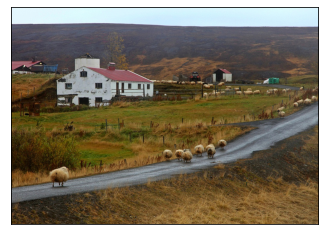

Model (5 ep) : a herd of sheep walking down a road
Model (2 ep) : a herd of sheep grazing on a hillside
GT 1 :  A herd of sheep walking down a rural country road.
GT 2 :  a herd of sheep walking down the road back to the farm 


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    189885  0.882497  0.882497  0.882497  0.882497  0.424897   
Model (2 ep)    189885  0.661873  0.577730  0.461332  0.362824  0.279437   

               ROUGE_L     CIDEr  
Model (5 ep)  0.871429  3.789821  
Model (2 ep)  0.698473  1.536464

------------------------------


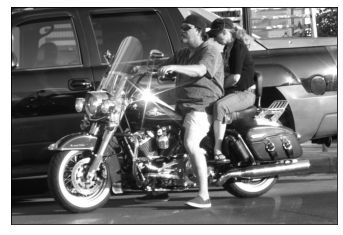

Model (5 ep) : a man and a woman are riding a motorcycle
Model (2 ep) : a man riding a motorcycle is riding down a street
GT 1 :  A man riding on the back of a motorcycle with a woman.
GT 2 :  there is a man and a woman that are riding a motorcycle


image_id  Bleu_1    Bleu_2    Bleu_3   Bleu_4    METEOR  \
Model (5 ep)    310553     1.0  1.000000  1.000000  1.00000  1.000000   
Model (2 ep)    310553     0.8  0.596285  0.446289  0.00006  0.322932   

               ROUGE_L     CIDEr  
Model (5 ep)  1.000000  3.880894  
Model (2 ep)  0.572949  1.631769

------------------------------


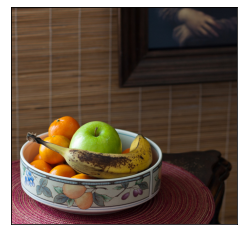

Model (5 ep) : a bowl of fruit on a table
Model (2 ep) : a bowl of fruit and a bowl of cereal
GT 1 :  a big bowl of different kinds of fruit inside
GT 2 :  A bowl of fruit that is sitting on a table.


image_id    Bleu_1   Bleu_2   Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    215901  1.000000  1.00000  1.00000  1.000000  1.000000   
Model (2 ep)    215901  0.777778  0.62361  0.48075  0.368894  0.331192   

               ROUGE_L     CIDEr  
Model (5 ep)  1.000000  3.962561  
Model (2 ep)  0.639413  1.687190

------------------------------


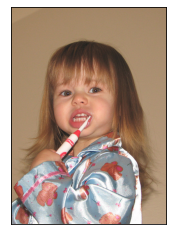

Model (5 ep) : a girl brushing her teeth with a toothbrush
Model (2 ep) : a little girl holding a little girl holding a little girl holding a little girl holding a little girl holding a little girl holding a little girl holding a little
GT 1 :  A small girl with long hair brushing her teeth
GT 2 :  A little girl brushing her teeth with an electric toothbrush.


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    187743  0.882497  0.817033  0.732319  0.675292  0.350849   
Model (2 ep)    187743  0.133333  0.095893  0.068993  0.000011  0.128233   

              ROUGE_L     CIDEr  
Model (5 ep)  0.76250  4.022931  
Model (2 ep)  0.21982  0.000413

------------------------------


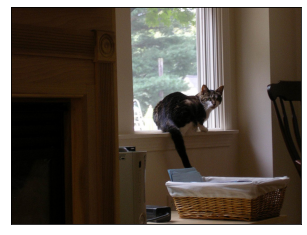

Model (5 ep) : a cat sitting on top of a window sill
Model (2 ep) : a cat is sitting on top of a window
GT 1 :  A cat sitting on top of a window sill.
GT 2 :  A cat is sitting in a window looking in the house.


image_id  Bleu_1  Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)    372979     1.0     1.0  1.000000  1.000000  1.000000   
Model (2 ep)    372979     1.0     1.0  0.949914  0.869442  0.466554   

               ROUGE_L     CIDEr  
Model (5 ep)  1.000000  4.276725  
Model (2 ep)  0.888889  2.647543

------------------------------


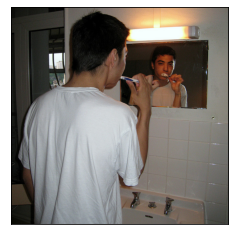

Model (5 ep) : a man brushing his teeth in a mirror
Model (2 ep) : a man is taking a picture of a man taking a picture of a man taking a picture of a man taking a picture of a man taking a picture
GT 1 :  A young guy standing by a mirror brushing his teeth.
GT 2 :  A man brushing his teeth in a mirror at a sink.


image_id    Bleu_1    Bleu_2        Bleu_3        Bleu_4  \
Model (5 ep)    260059  0.778801  0.778801  7.788008e-01  7.788008e-01   
Model (2 ep)    260059  0.200000  0.143839  9.040624e-07  2.287220e-09   

                METEOR   ROUGE_L     CIDEr  
Model (5 ep)  0.477351  0.871429  5.056103  
Model (2 ep)  0.110231  0.219820  0.000529

------------------------------


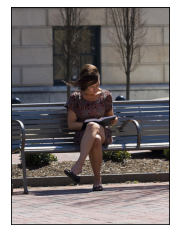

Model (5 ep) : a woman sitting on a bench reading a book
Model (2 ep) : a woman sitting on a bench reading a book
GT 1 :  a person sitting on a bench reading a book
GT 2 :  A woman sitting on a bench reading a book


image_id  Bleu_1  Bleu_2  Bleu_3  Bleu_4  METEOR  ROUGE_L  \
Model (5 ep)    314193     1.0     1.0     1.0     1.0     1.0      1.0   
Model (2 ep)    314193     1.0     1.0     1.0     1.0     1.0      1.0   

                 CIDEr  
Model (5 ep)  5.698228  
Model (2 ep)  5.698228

------------------------------


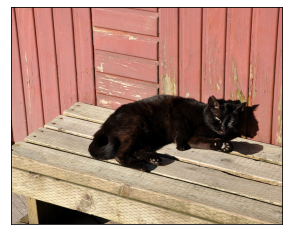

Model (5 ep) : a black cat laying on a wooden bench
Model (2 ep) : a cat sitting on a bench
GT 1 :  A cat laying on top of a wooden bench.
GT 2 :  A black cat laying on a wooden bench.


image_id    Bleu_1    Bleu_2    Bleu_3    Bleu_4    METEOR  \
Model (5 ep)     46316  1.000000  1.000000  1.000000  1.000000  1.000000   
Model (2 ep)     46316  0.716531  0.640885  0.604346  0.569836  0.330865   

               ROUGE_L     CIDEr  
Model (5 ep)  1.000000  5.848075  
Model (2 ep)  0.738499  1.978373

------------------------------


In [18]:
best_cap = eval_sorted_newCA[-n_visu:]
plot_image_captions(best_cap,coco_eval_sort_newCA[-1], coco_eval_sort_newCA[0], model_names=['Model (5 ep)', 'Model (2 ep)'])